# Flood Prediction - Regression Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor

from math import exp, pow, sqrt, log

from joblib import Parallel, delayed # For the parallelization

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3' # Use GPU 3 for training

In [2]:
data = pd.read_csv('Flut-Daten.csv')

### Datenvorbereitung

Targets erstellen

In [3]:
for i in range(1, 7):  # Targets for 1 to 6 hours in the future
    data[f'target_h{i}'] = data['Q'].shift(-i)
data = data.dropna()

#### Feature Selection

In [4]:
results = {}

features = data[['pr', 'Q_lag_1',
               'Q_lag_2', 'Q_lag_4', 'Q_lag_6',
               'Gesamt_pr_6h', 'Gesamt_pr_12h', 'Gesamt_pr_24h',
               'Gesamt_Q_6h', 'Gesamt_Q_12h', 'Gesamt_Q_24h',
               'rolling_mean_Q_6h', 'rolling_mean_pr_6h',
               'exp_smooth_Q_3h', 'exp_smooth_pr_3h', 'pr_to_Q_ratio',
               'alltime_monthly_avg_pr', 'alltime_monthly_avg_Q', 'pr_lag_7']]

#### Modell in Schleife Trainieren und Evaluieren

Ohne Begrenzung der Maximalen Tiefe

In [ ]:
for i in range(1, 7):
    target = data[f'target_h{i}']
    
    # Create training and test data (time series approach --> shuffle=False!)
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size=0.2, 
        random_state=42,
        shuffle=False
    )

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=42)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    results[f'hour_{i}'] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': test_predictions,
        'y_test': y_test
    }
    
    print(f"Results for hour {i}:")
    print("  Training RMSE:", train_rmse)
    print("  Test RMSE:", test_rmse)
    print("  Training R^2:", train_r2)
    print("  Test R^2:", test_r2)
    print()

Ergebnisse für Stunde 1:
  Training RMSE: 0.0004245174337576698
  Test RMSE: 0.3760836780738625
  Training R^2: 0.9999999817575319
  Test R^2: 0.9858886501234512

Ergebnisse für Stunde 2:
  Training RMSE: 0.0005801794497500654
  Test RMSE: 0.5498078795086246
  Training R^2: 0.9999999659229087
  Test R^2: 0.9698476858412969

Ergebnisse für Stunde 3:
  Training RMSE: 0.00041091654488407996
  Test RMSE: 0.6546943557720755
  Training R^2: 0.9999999829272213
  Test R^2: 0.9571228510560885

Ergebnisse für Stunde 4:
  Training RMSE: 0.000469841110660259
  Test RMSE: 0.8138081567091806
  Training R^2: 0.9999999777145315
  Test R^2: 0.9335090742213658

Ergebnisse für Stunde 5:
  Training RMSE: 0.0003514743293259579
  Test RMSE: 0.9205609425056771
  Training R^2: 0.9999999875183342
  Test R^2: 0.9150858379172072

Ergebnisse für Stunde 6:
  Training RMSE: 0.0004937949281362206
  Test RMSE: 0.9982626317018983
  Training R^2: 0.9999999753532839
  Test R^2: 0.900241312089758



As can be seen, the model has significantly overfitted. The training data is almost perfectly matched, while the test data performs much worse.
 
## Hyperparameter Optimization
What leads to the best model?

In [ ]:
# Hyperparameter ranges
max_depth_values = [3, 5, 10, 15, 20]
min_samples_split_values = [2, 5, 10, 20]
min_samples_leaf_values = [1, 2, 5, 10]

def train_and_evaluate(X_train, y_train, X_test, y_test, depth, min_split, min_leaf):
    model = DecisionTreeRegressor(
        random_state=42, 
        max_depth=depth, 
        min_samples_split=min_split, 
        min_samples_leaf=min_leaf
    )
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    return model, test_rmse, {'max_depth': depth, 'min_samples_split': min_split, 'min_samples_leaf': min_leaf}

results = {}

for i in range(1, 7):
    target = data[f'target_h{i}']

    # Create training and test data (time series approach --> shuffle=False!)
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size=0.2, 
        random_state=42,
        shuffle=False
    )

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Prepare all hyperparameter combinations
    param_combinations = [
        (depth, min_split, min_leaf) 
        for depth in max_depth_values 
        for min_split in min_samples_split_values 
        for min_leaf in min_samples_leaf_values
    ]

    # Parallel train and evaluate
    results_list = Parallel(n_jobs=-1)(
        delayed(train_and_evaluate)(X_train, y_train, X_test, y_test, depth, min_split, min_leaf)
        for depth, min_split, min_leaf in param_combinations
    )

    # Find the best model
    best_model, best_rmse, best_params = min(results_list, key=lambda x: x[1])

    train_predictions = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, best_model.predict(X_test))

    results[f'hour_{i}'] = {
        'model': best_model,
        'best_params': best_params,
        'train_rmse': train_rmse,
        'test_rmse': best_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': best_model.predict(X_test),
        'y_test': y_test
    }

    print(f"Results for hour {i}:")
    print(f"  Best parameters: {best_params}")
    print("  Train RMSE:", train_rmse)
    print("  Test RMSE:", best_rmse)
    print("  Train R^2:", train_r2)
    print("  Test R^2:", test_r2)
    print()

Ergebnisse für Stunde 1:
  Beste Parameter: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10}
  Training RMSE: 0.22964700884068615
  Test RMSE: 0.36345002350658323
  Training R^2: 0.9946000583236739
  Test R^2: 0.9871184148286178

Ergebnisse für Stunde 2:
  Beste Parameter: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}
  Training RMSE: 0.33810484904842175
  Test RMSE: 0.4893931688364702
  Training R^2: 0.988294984847604
  Test R^2: 0.9766442535856357

Ergebnisse für Stunde 3:
  Beste Parameter: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}
  Training RMSE: 0.4232820259219257
  Test RMSE: 0.6033951832884563
  Training R^2: 0.9816544536243337
  Test R^2: 0.9644958565666547

Ergebnisse für Stunde 4:
  Beste Parameter: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 10}
  Training RMSE: 0.5078214892299568
  Test RMSE: 0.7086363130369332
  Training R^2: 0.9735944677202063
  Test R^2: 0.9510311633298092

Ergebnisse für Stu

The best model for all predictions (except for hour 1) has the parameters `max_depth = 10`, `min_samples_split = 2`, and `min_samples_leaf = 10`.
Let's train this model again and examine it more closely.

In [ ]:
results = {}

for i in range(1, 7):
    target = data[f'target_h{i}']

    # Create training and test data (time series approach --> shuffle=False!)
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size=0.2, 
        random_state=42,
        shuffle=False
    )

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = DecisionTreeRegressor(
        random_state=42, 
        max_depth=10, 
        min_samples_split=2, 
        min_samples_leaf=10
    )
    model.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    results[f'hour_{i}'] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': test_predictions,
        'y_test': y_test
    }

    print(f"Results for hour {i}:")
    print(f"  Train RMSE: {train_rmse}")
    print(f"  Test RMSE: {test_rmse}")
    print(f"  Train R^2: {train_r2}")
    print(f"  Test R^2: {test_r2}")
    print()

Ergebnisse für Stunde 1:
  Training RMSE: 0.24979862324650529
  Test RMSE: 0.3672894109245373
  Training R^2: 0.9936107840988451
  Test R^2: 0.9868448222020126

Ergebnisse für Stunde 2:
  Training RMSE: 0.33810484904842175
  Test RMSE: 0.4893931688364702
  Training R^2: 0.988294984847604
  Test R^2: 0.9766442535856357

Ergebnisse für Stunde 3:
  Training RMSE: 0.4232820259219257
  Test RMSE: 0.6033951832884563
  Training R^2: 0.9816544536243337
  Test R^2: 0.9644958565666547

Ergebnisse für Stunde 4:
  Training RMSE: 0.5078214892299568
  Test RMSE: 0.7086363130369332
  Training R^2: 0.9735944677202063
  Test R^2: 0.9510311633298092

Ergebnisse für Stunde 5:
  Training RMSE: 0.5864336625291058
  Test RMSE: 0.8074705963074948
  Training R^2: 0.9647862386754914
  Test R^2: 0.9364195449619638

Ergebnisse für Stunde 6:
  Training RMSE: 0.647926445854503
  Test RMSE: 0.8854148592627752
  Training R^2: 0.9570139139908984
  Test R^2: 0.9235528975346712



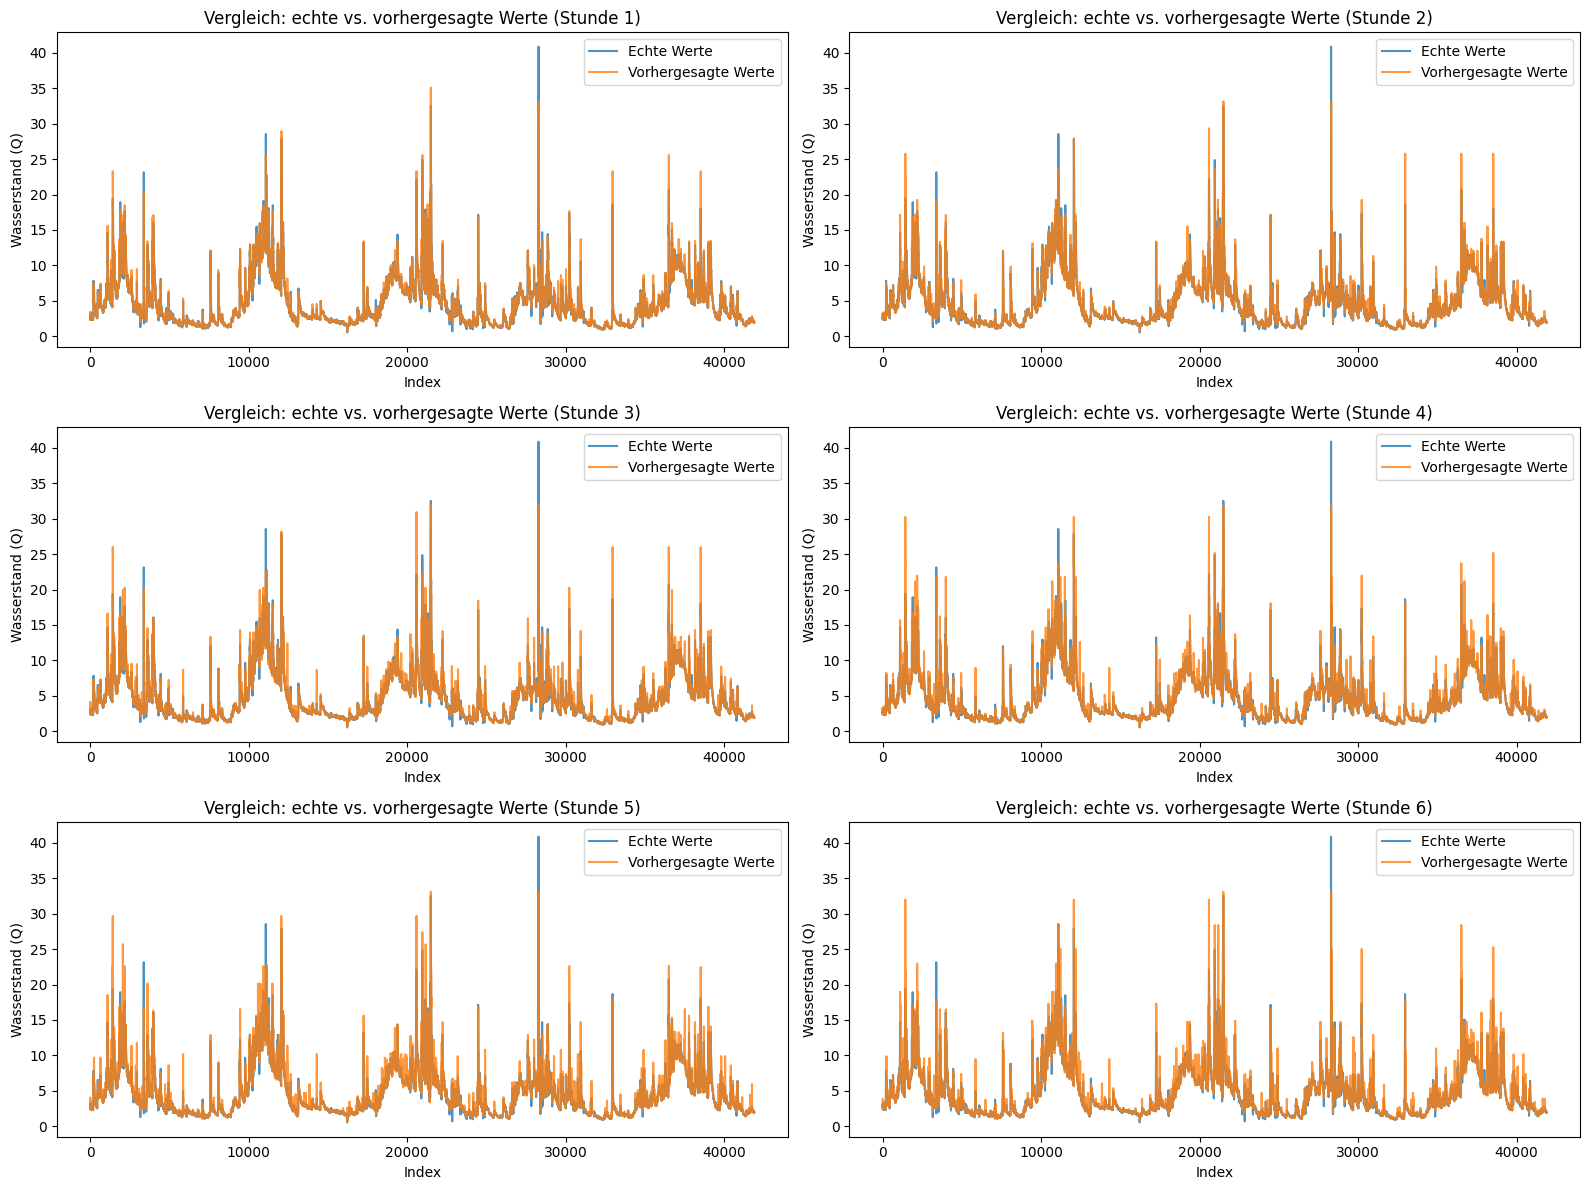

In [8]:
plt.figure(figsize=(16, 12))
for i in range(1, 7):
    plt.subplot(3, 2, i)
    plt.plot(results[f'hour_{i}']['y_test'].values, label="Actual values", alpha=0.8)
    plt.plot(results[f'hour_{i}']['test_predictions'], label="Predicted values", alpha=0.8)
    plt.title(f"Comparison: actual vs. predicted values (Hour {i})")
    plt.xlabel("Index")
    plt.ylabel("Water level (Q)")
    plt.legend()

plt.tight_layout()
plt.show()

As you can see, the prediction is already quite accurate :)

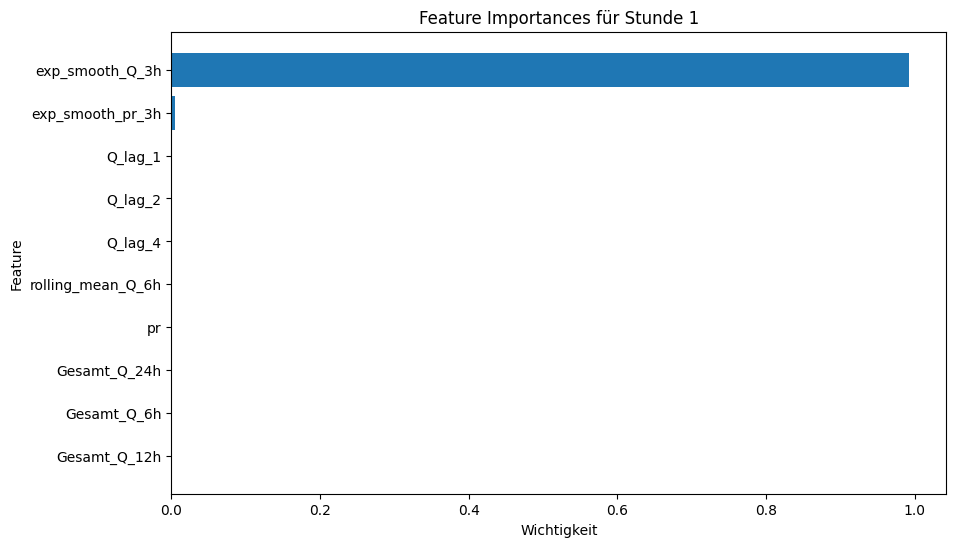

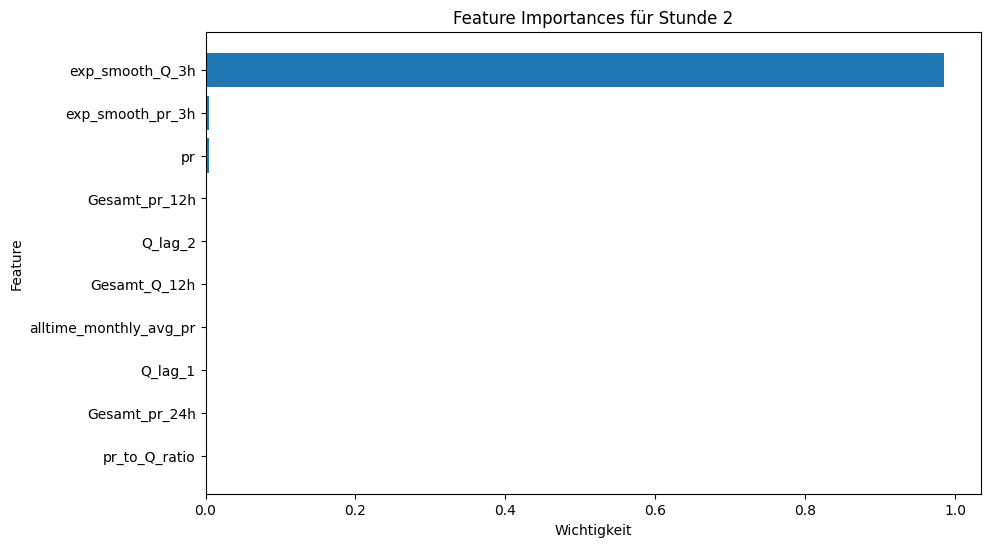

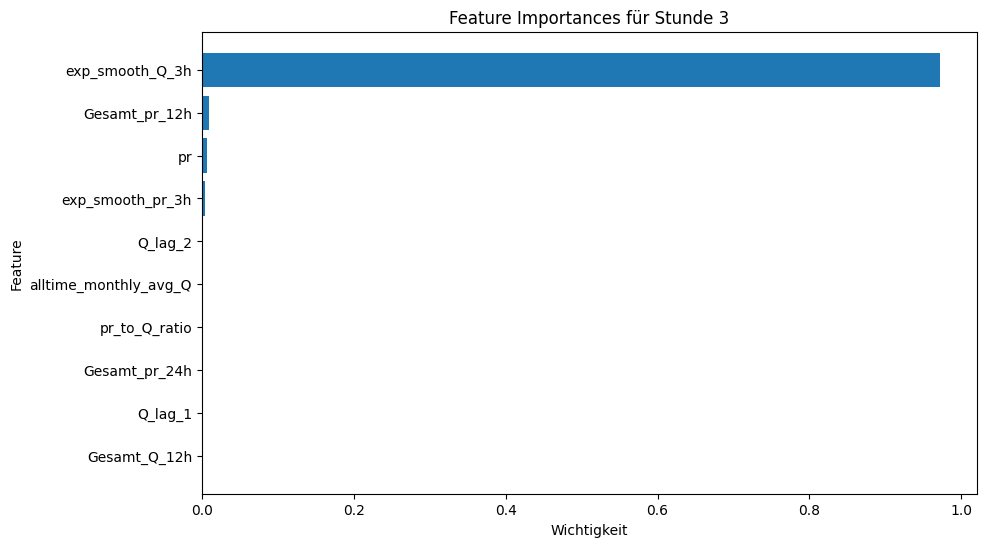

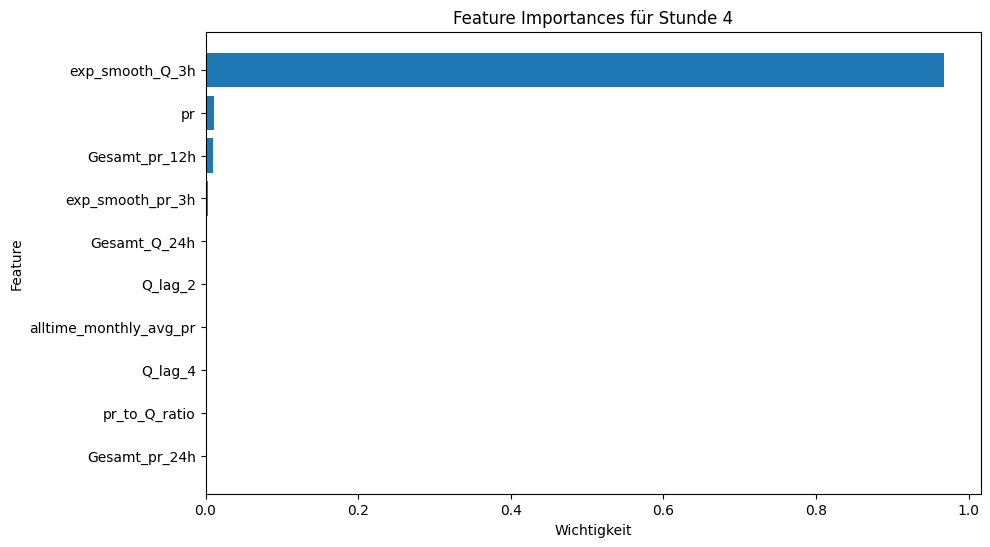

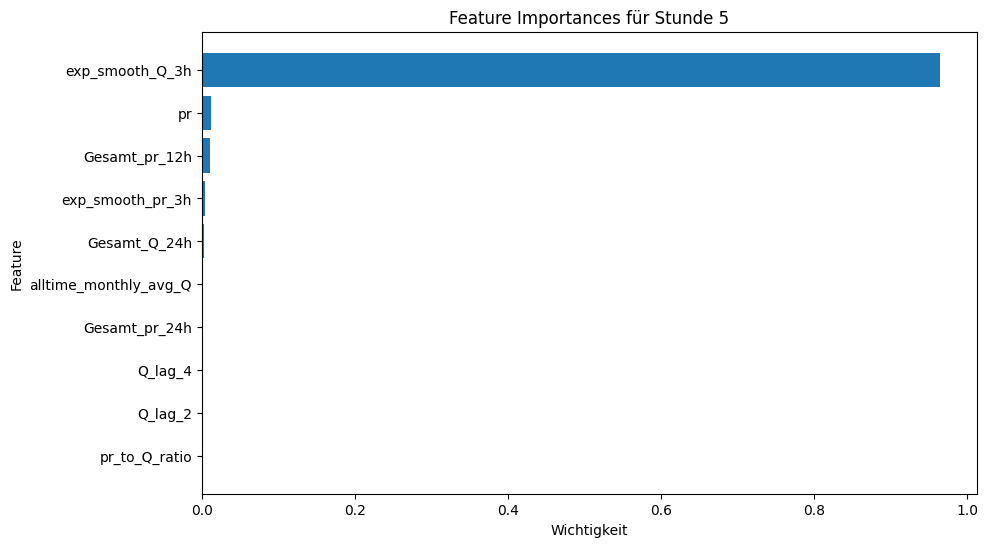

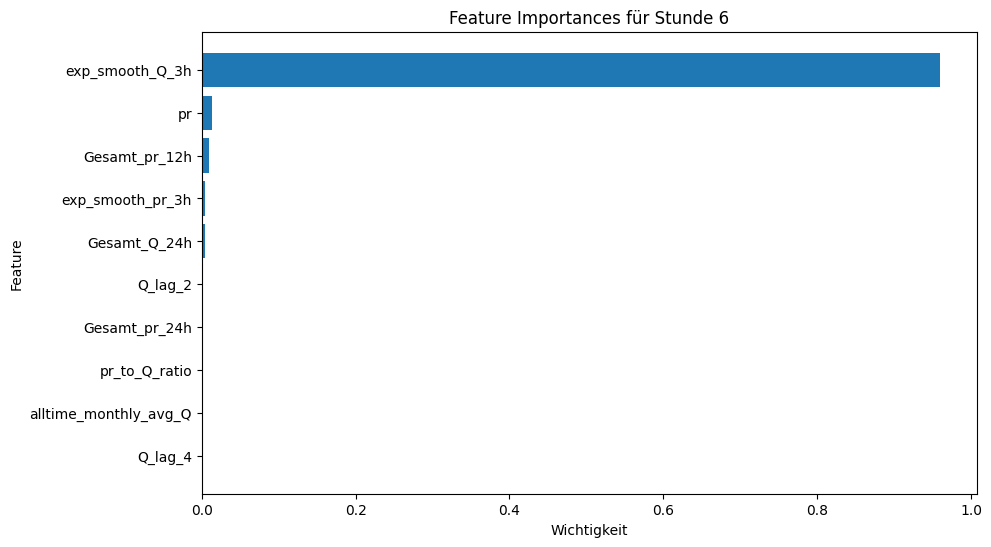

In [ ]:
for i in range(1, 7):
    model = results[f'hour_{i}']['model']
    feature_importances = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': features.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'].iloc[:10], importance_df['Importance'].iloc[:10])
    plt.title(f"Feature Importances for hour {i}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()  # Most important feature at the top
    plt.show()

It seems that only one feature is truly being used. The low importance of the other features might indicate that they are either redundant or have little influence on the target variable.

# Bagging, Random Forest, Boosting
Can we improve our results?

### 1) Bagging


In [11]:
AutoBagReg = BaggingRegressor(estimator=DecisionTreeRegressor(),
                              n_estimators=10, random_state=42, bootstrap=True).fit(X_train, y_train) 

y_hat_train_Bag = AutoBagReg.predict(X_train)
y_hat_test_Bag = AutoBagReg.predict(X_test)

rmseTree_Bag_tr = sqrt(mean_squared_error(y_hat_train_Bag,y_train)) 
rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag,y_test)) 

print('Training error:',rmseTree_Bag_tr)
print('Test error:',rmseTree_Bag_test)

AutoBagReg_test_r2=AutoBagReg.score(X_test,y_test)

AutoBagReg_test_r2

Trainingsfehler: 0.3050776945619625
Testfehler: 0.870978416989254


0.9260254718947384

What if we combine bagging and hyperparameter optimization?

In [12]:
# Hyperparameter-Ranges für DecisionTreeRegressor
param_grid = {
    'max_depth': [3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize results
results = {}

# Loop over the 6-hour-prediction
for i in range(1, 7):
    print(f"Optimierung und Vorhersage für Stunde {i}...")

    # Target variable for this hour
    target = data[f'target_h{i}']

    # Generate training and test data (time series approach --> shuffle=False!)
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size=0.2, 
        random_state=42,
        shuffle=False
    )

    # Feature-Scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Hyperparameter-Tuning for DecisionTreeRegressor
    grid_search = GridSearchCV(
        estimator=DecisionTreeRegressor(random_state=42),
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best DecisionTree model
    best_tree = grid_search.best_estimator_

    # Bagging-Regressor with optimized DecisionTree
    bagging = BaggingRegressor(estimator=best_tree, n_estimators=50, random_state=42, n_jobs=-1)
    bagging.fit(X_train, y_train)

    # Predictions
    train_predictions = bagging.predict(X_train)
    test_predictions = bagging.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Save results
    results[f'hour_{i}'] = {
        'model': bagging,
        'best_params': grid_search.best_params_,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': test_predictions,
        'y_test': y_test
    }

    # Print best parameters
    print(f"Results for hour {i}:")
    print(f"  Best parameters: {grid_search.best_params_}")
    print("  Training RMSE:", train_rmse)
    print("  Test RMSE:", test_rmse)
    print("  Training R^2:", train_r2)
    print("  Test R^2:", test_r2)
    print()

# Print results
for hour, metrics in results.items():
    print(f"Stunde: {hour}")
    print(f"  Beste Parameter: {metrics['best_params']}")
    print(f"  Train RMSE: {metrics['train_rmse']}")
    print(f"  Test RMSE: {metrics['test_rmse']}")
    print(f"  Train R^2: {metrics['train_r2']}")
    print(f"  Test R^2: {metrics['test_r2']}")
    print()

Optimierung und Vorhersage für Stunde 1...
Ergebnisse für Stunde 1:
  Beste Parameter: {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 2}
  Training RMSE: 0.22616175697791854
  Test RMSE: 0.32362392094144543
  Training R^2: 0.9947627196555222
  Test R^2: 0.9897868164384191

Optimierung und Vorhersage für Stunde 2...
Ergebnisse für Stunde 2:
  Beste Parameter: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
  Training RMSE: 0.32856005049819487
  Test RMSE: 0.4560700243755207
  Training R^2: 0.9889465285298183
  Test R^2: 0.9797165884387002

Optimierung und Vorhersage für Stunde 3...
Ergebnisse für Stunde 3:
  Beste Parameter: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
  Training RMSE: 0.4082583291707786
  Test RMSE: 0.5579492925644222
  Training R^2: 0.98293363207873
  Test R^2: 0.9696425824681789

Optimierung und Vorhersage für Stunde 4...
Ergebnisse für Stunde 4:
  Beste Parameter: {'max_depth': 15, 'min_samples_leaf': 10, 'min_s

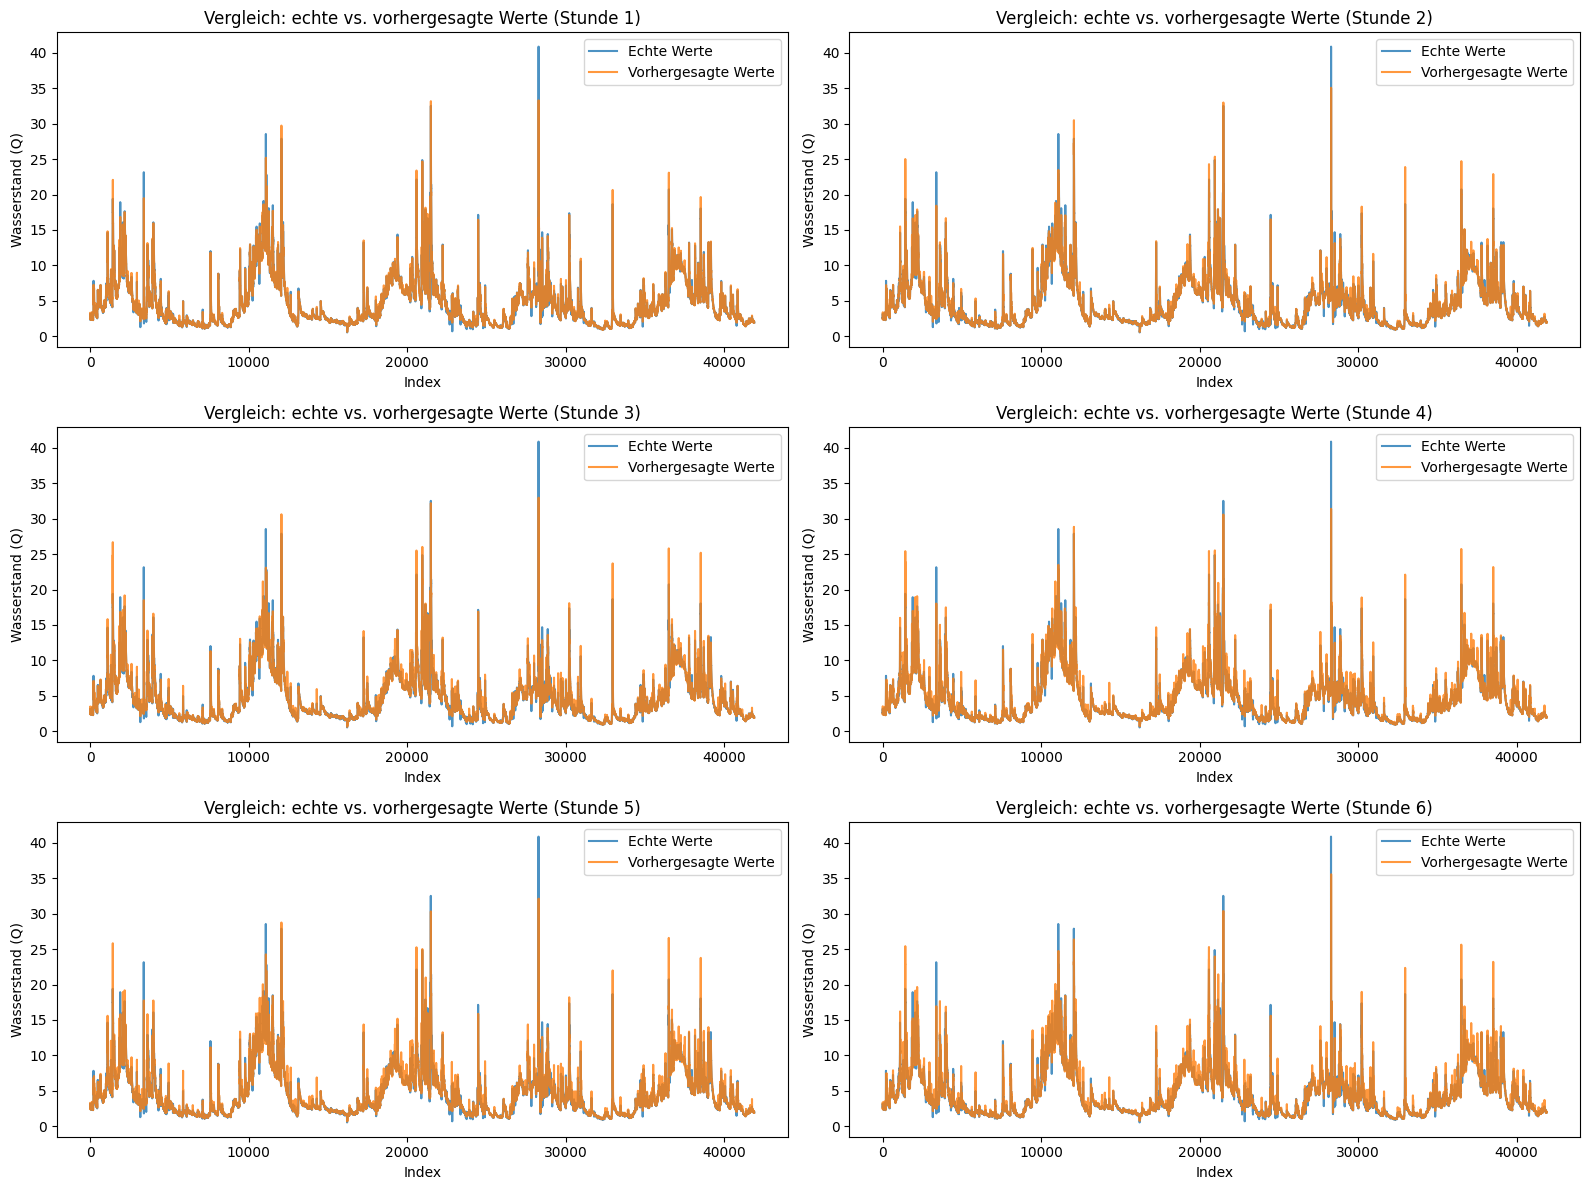

In [13]:
def visualize_predictions(results):
    plt.figure(figsize=(16, 12))
    for i in range(1, 7):
        plt.subplot(3, 2, i)
        y_test = results[f'hour_{i}']['y_test'].reset_index(drop=True)  # Reset index if needed
        test_predictions = results[f'hour_{i}']['test_predictions']

        plt.plot(y_test, label="Echte Werte", alpha=0.8)
        plt.plot(test_predictions, label="Vorhergesagte Werte", alpha=0.8)
        plt.title(f"Vergleich: echte vs. vorhergesagte Werte (Stunde {i})")
        plt.xlabel("Index")
        plt.ylabel("Wasserstand (Q)")
        plt.legend()

    plt.tight_layout()
    plt.show()

visualize_predictions(results)

### 2) Random Forest

Training und Vorhersage für Stunde 1...
Ergebnisse für Stunde 1:
  Training RMSE: 0.18695736552653633
  Test RMSE: 0.33533084233013
  Training R^2: 0.9964210746305229
  Test R^2: 0.9890345386995222

Training und Vorhersage für Stunde 2...
Ergebnisse für Stunde 2:
  Training RMSE: 0.26266835335048266
  Test RMSE: 0.4657478804764699
  Training R^2: 0.9929354470512302
  Test R^2: 0.9788466225086052

Training und Vorhersage für Stunde 3...
Ergebnisse für Stunde 3:
  Training RMSE: 0.335188546239284
  Test RMSE: 0.5674926622984171
  Training R^2: 0.9884959877336381
  Test R^2: 0.9685952122704385

Training und Vorhersage für Stunde 4...
Ergebnisse für Stunde 4:
  Training RMSE: 0.4088744555389356
  Test RMSE: 0.6627978934081663
  Training R^2: 0.982882011332925
  Test R^2: 0.9571614049681008

Training und Vorhersage für Stunde 5...
Ergebnisse für Stunde 5:
  Training RMSE: 0.4805671215849497
  Test RMSE: 0.7480610344723791
  Training R^2: 0.9763526356720309
  Test R^2: 0.9454312173406055

Tr

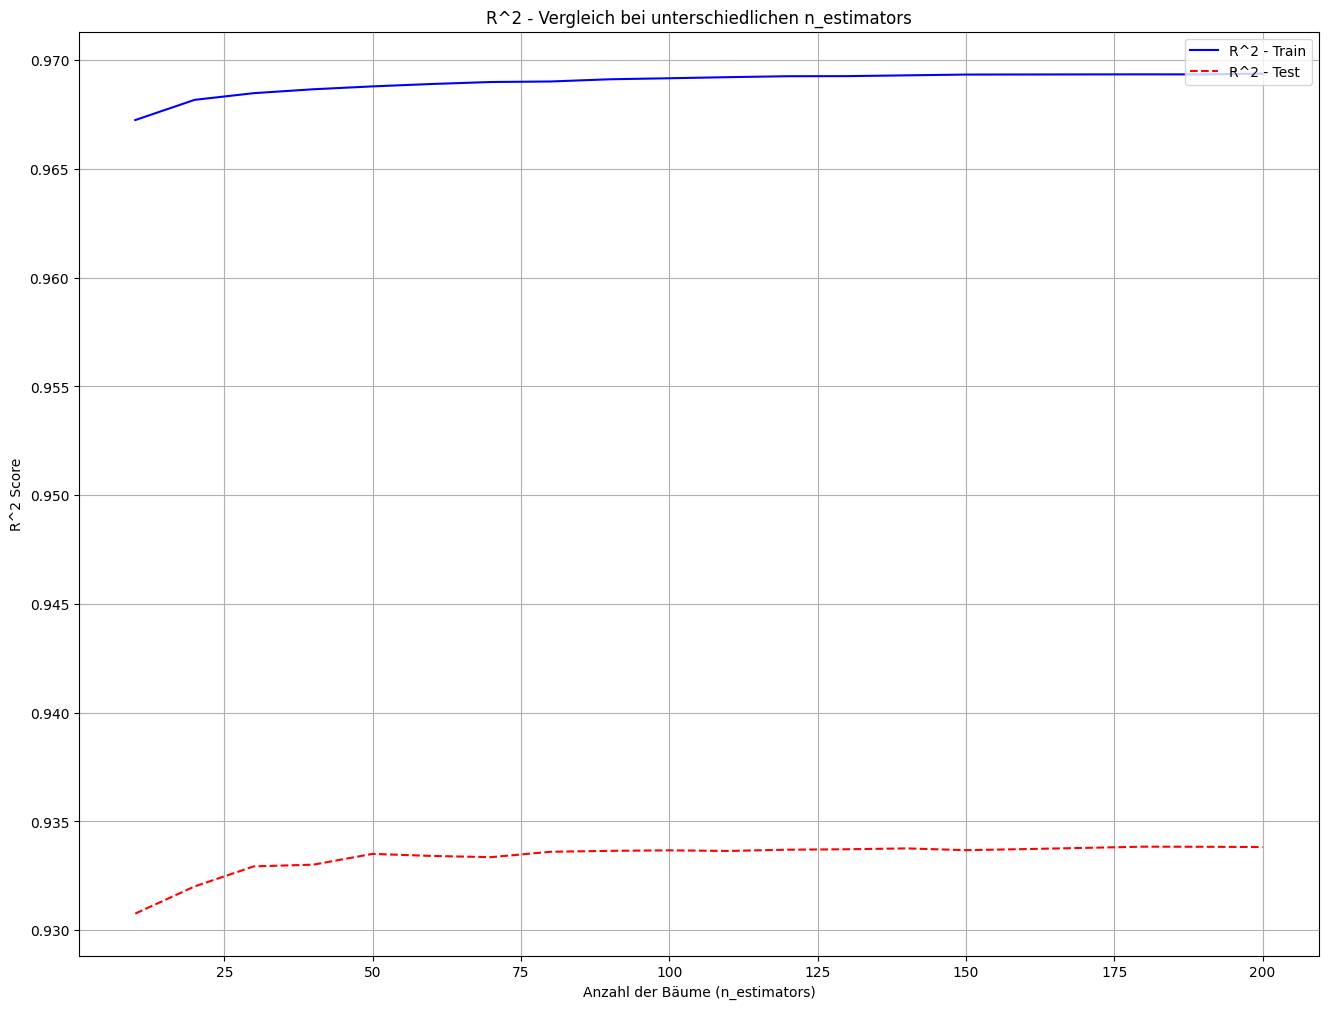

In [14]:
# Initialize results
results_rf = {}

# Loop over the 6-hour forecast
for i in range(1, 7):
    print(f"Training and prediction for hour {i}...")

    # Target variable for this hour
    target = data[f'target_h{i}']

    # Create training and test data (time series approach --> shuffle=False!)
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size=0.2, 
        random_state=42,
        shuffle=False
    )

    # Feature scaling
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train Random Forest
    model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    model_rf.fit(X_train, y_train)

    # Calculate predictions
    train_predictions = model_rf.predict(X_train)
    test_predictions = model_rf.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Save results
    results_rf[f'hour_{i}'] = {
        'model': model_rf,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': test_predictions,
        'y_test': y_test
    }

    # Output results
    print(f"Results for hour {i}:")
    print(f"  Training RMSE: {train_rmse}")
    print(f"  Test RMSE: {test_rmse}")
    print(f"  Training R^2: {train_r2}")
    print(f"  Test R^2: {test_r2}")
    print()

# Visualization of the number of trees and their impact on test/train accuracy
n_estimators_list = []
train_score_list = []
test_score_list = []

for k in range(10, 201, 10):
    model_rf = RandomForestRegressor(n_estimators=k, max_depth=10, random_state=42, n_jobs=-1)
    model_rf.fit(X_train, y_train)

    train_score = model_rf.score(X_train, y_train)
    test_score = model_rf.score(X_test, y_test)

    train_score_list.append(train_score)
    test_score_list.append(test_score)
    n_estimators_list.append(k)

# Plot
plt.figure(figsize=(16, 12))
plt.plot(n_estimators_list, train_score_list, 'b-', label='R^2 - Train')
plt.plot(n_estimators_list, test_score_list, 'r--', label='R^2 - Test')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('R^2 Score')
plt.title('R^2 - Comparison at different n_estimators')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Here you can see that a plateau is reached after only a few attempts. Therefore, using more than 100 trees in the Random Forest is not very useful.

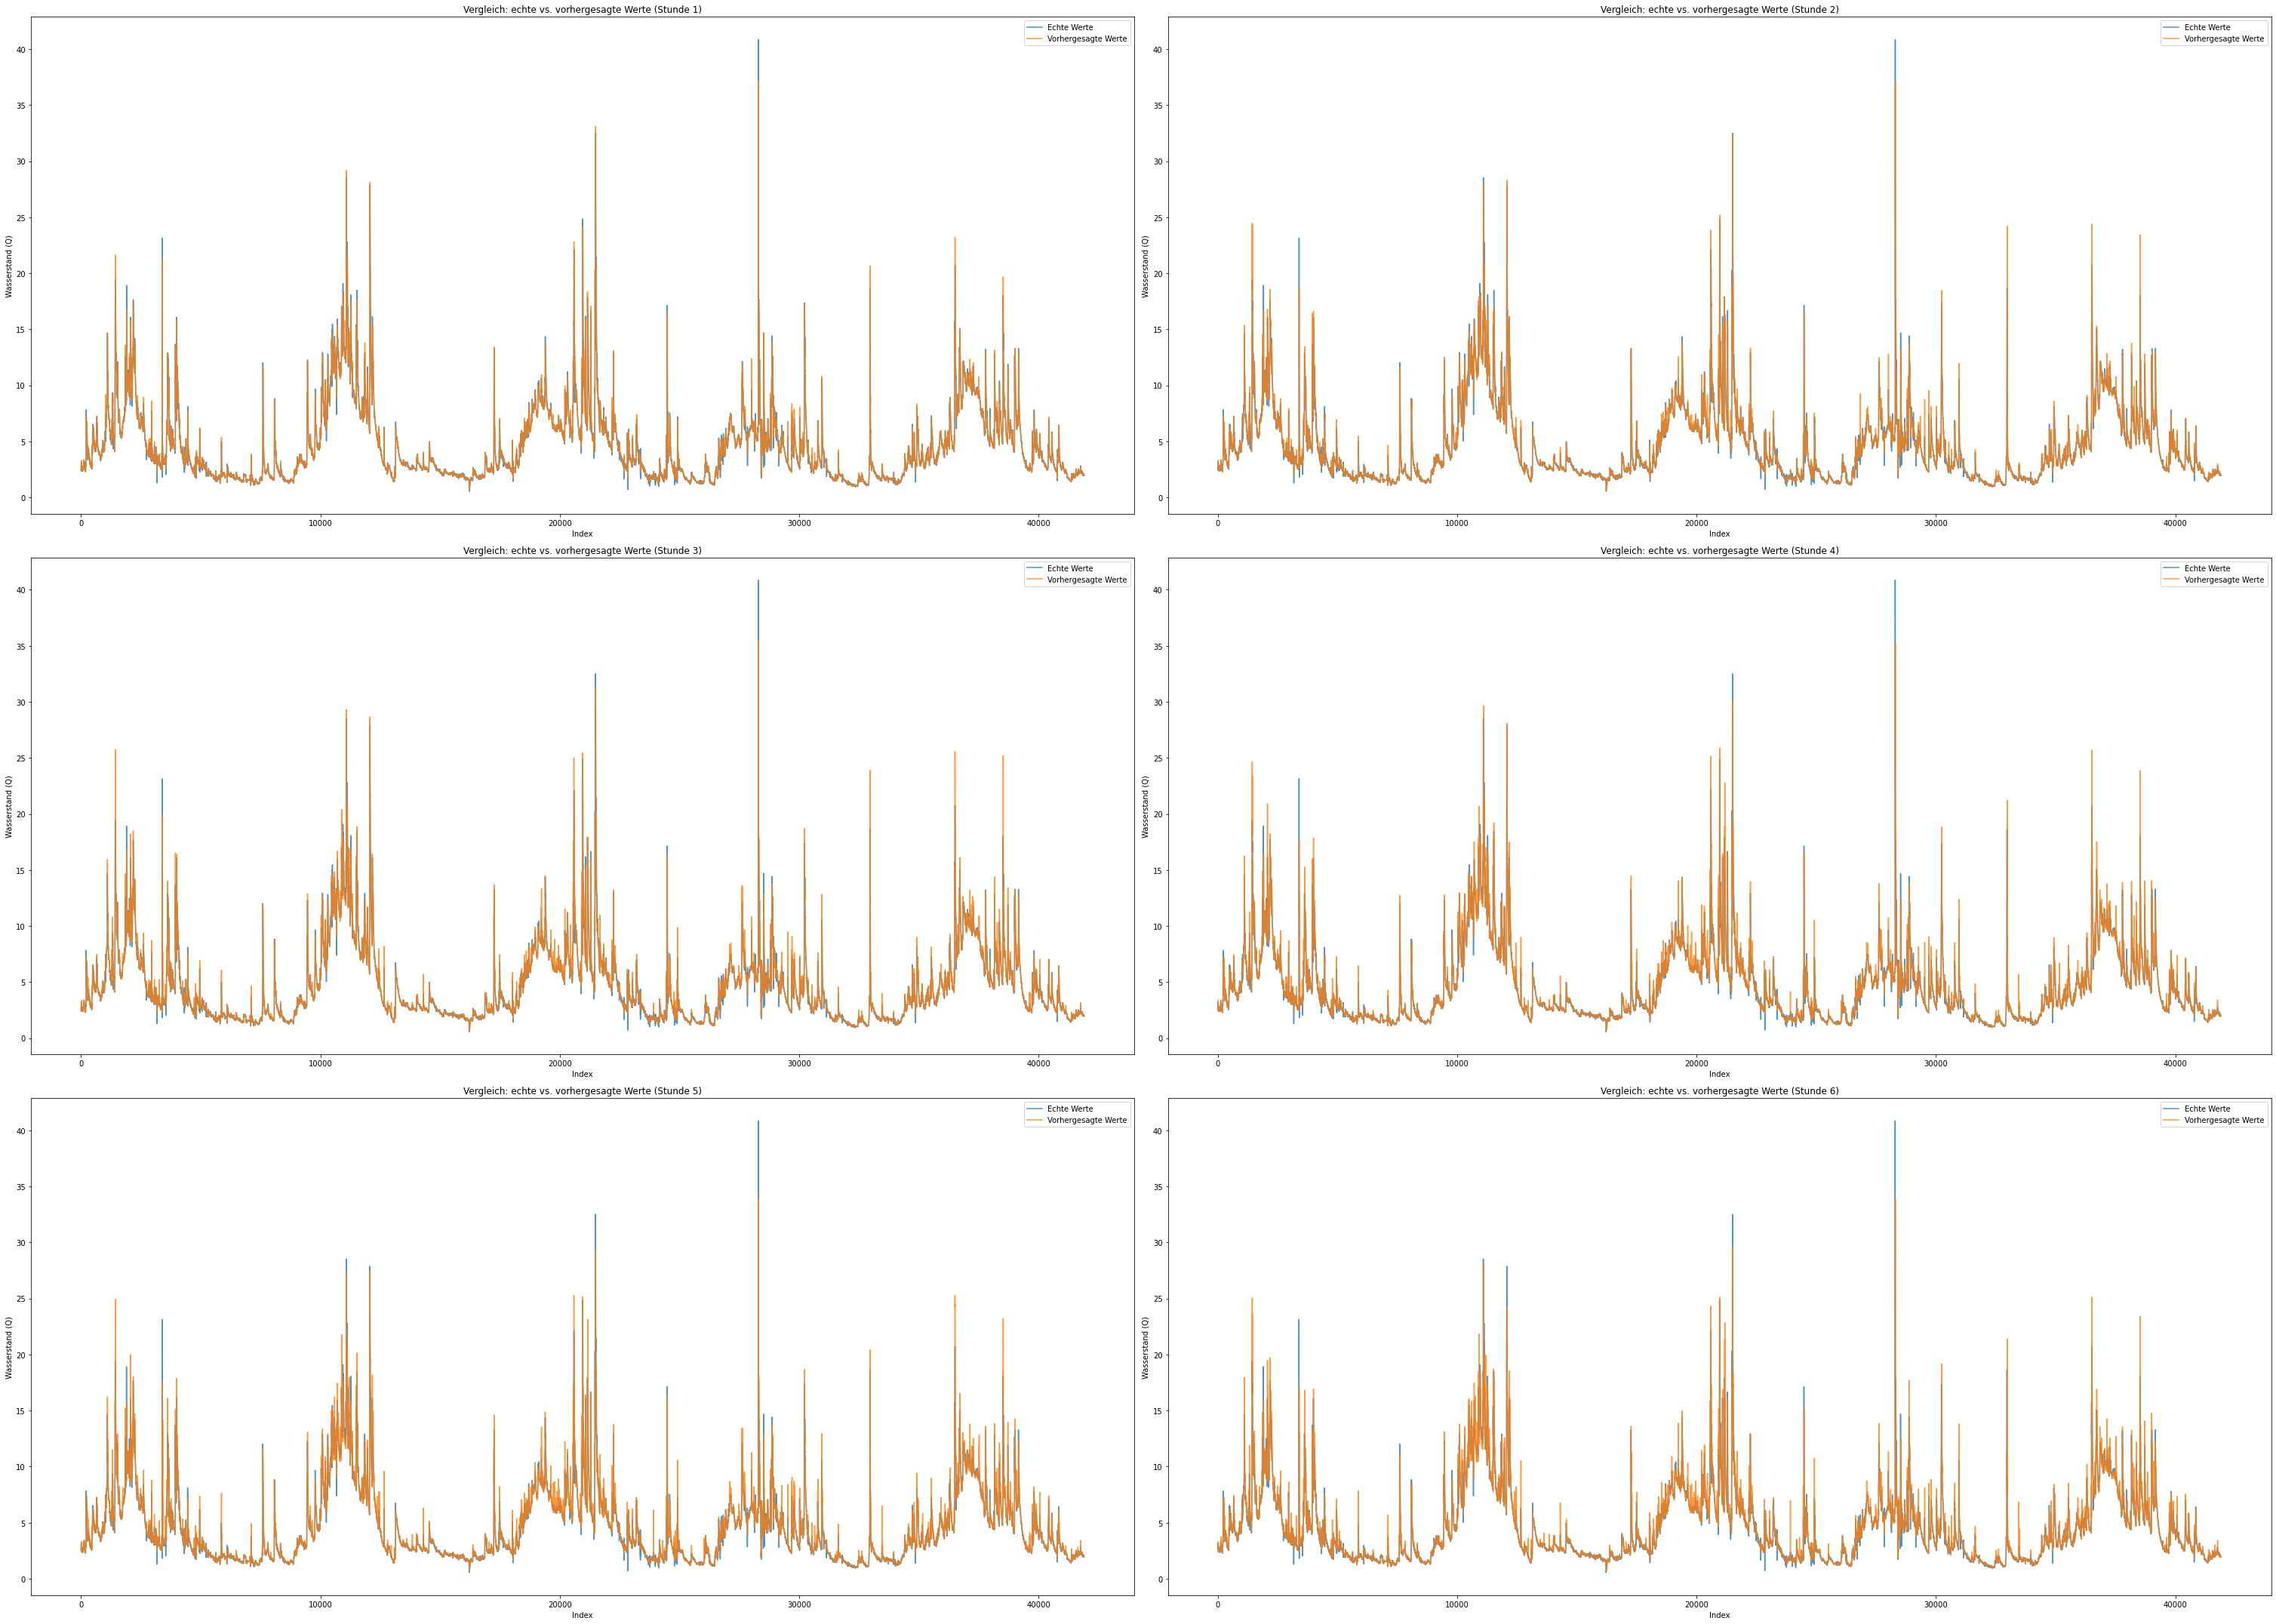

In [28]:
visualize_predictions(results_rf)

### 3) Boosting

Optimierung und Training für Stunde 1...
Ergebnisse für Stunde 1:
  Beste Parameter: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
  Training RMSE: 0.12600101304459332
  Test RMSE: 0.33564038436971066
  Training R^2: 0.998374393015288
  Test R^2: 0.989014285042872

Optimierung und Training für Stunde 2...
Ergebnisse für Stunde 2:
  Beste Parameter: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
  Training RMSE: 0.17971140382935602
  Test RMSE: 0.46121911355459244
  Training R^2: 0.9966931046237638
  Test R^2: 0.9792559983272578

Optimierung und Training für Stunde 3...
Ergebnisse für Stunde 3:
  Beste Parameter: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
  Training RMSE: 0.22942534996185532
  Test RMSE: 0.5694566001296549
  Training R^2: 0.9946104339081453
  Test R^2: 0.9683774692807525

Optimie

/data/home/fum43851/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Ergebnisse für Stunde 4:
  Beste Parameter: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
  Training RMSE: 0.28411225032768234
  Test RMSE: 0.6691935975416926
  Training R^2: 0.9917348127539146
  Test R^2: 0.9563306694185479

Optimierung und Training für Stunde 5...
Ergebnisse für Stunde 5:
  Beste Parameter: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
  Training RMSE: 0.3378710784413028
  Test RMSE: 0.7570018623673127
  Training R^2: 0.9883110185665146
  Test R^2: 0.9441190096367811

Optimierung und Training für Stunde 6...
Ergebnisse für Stunde 6:
  Beste Parameter: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
  Training RMSE: 0.3931326870632819
  Test RMSE: 0.839770299403787
  Training R^2: 0.9841745962157391
  Test R^2: 0.9312316762766992



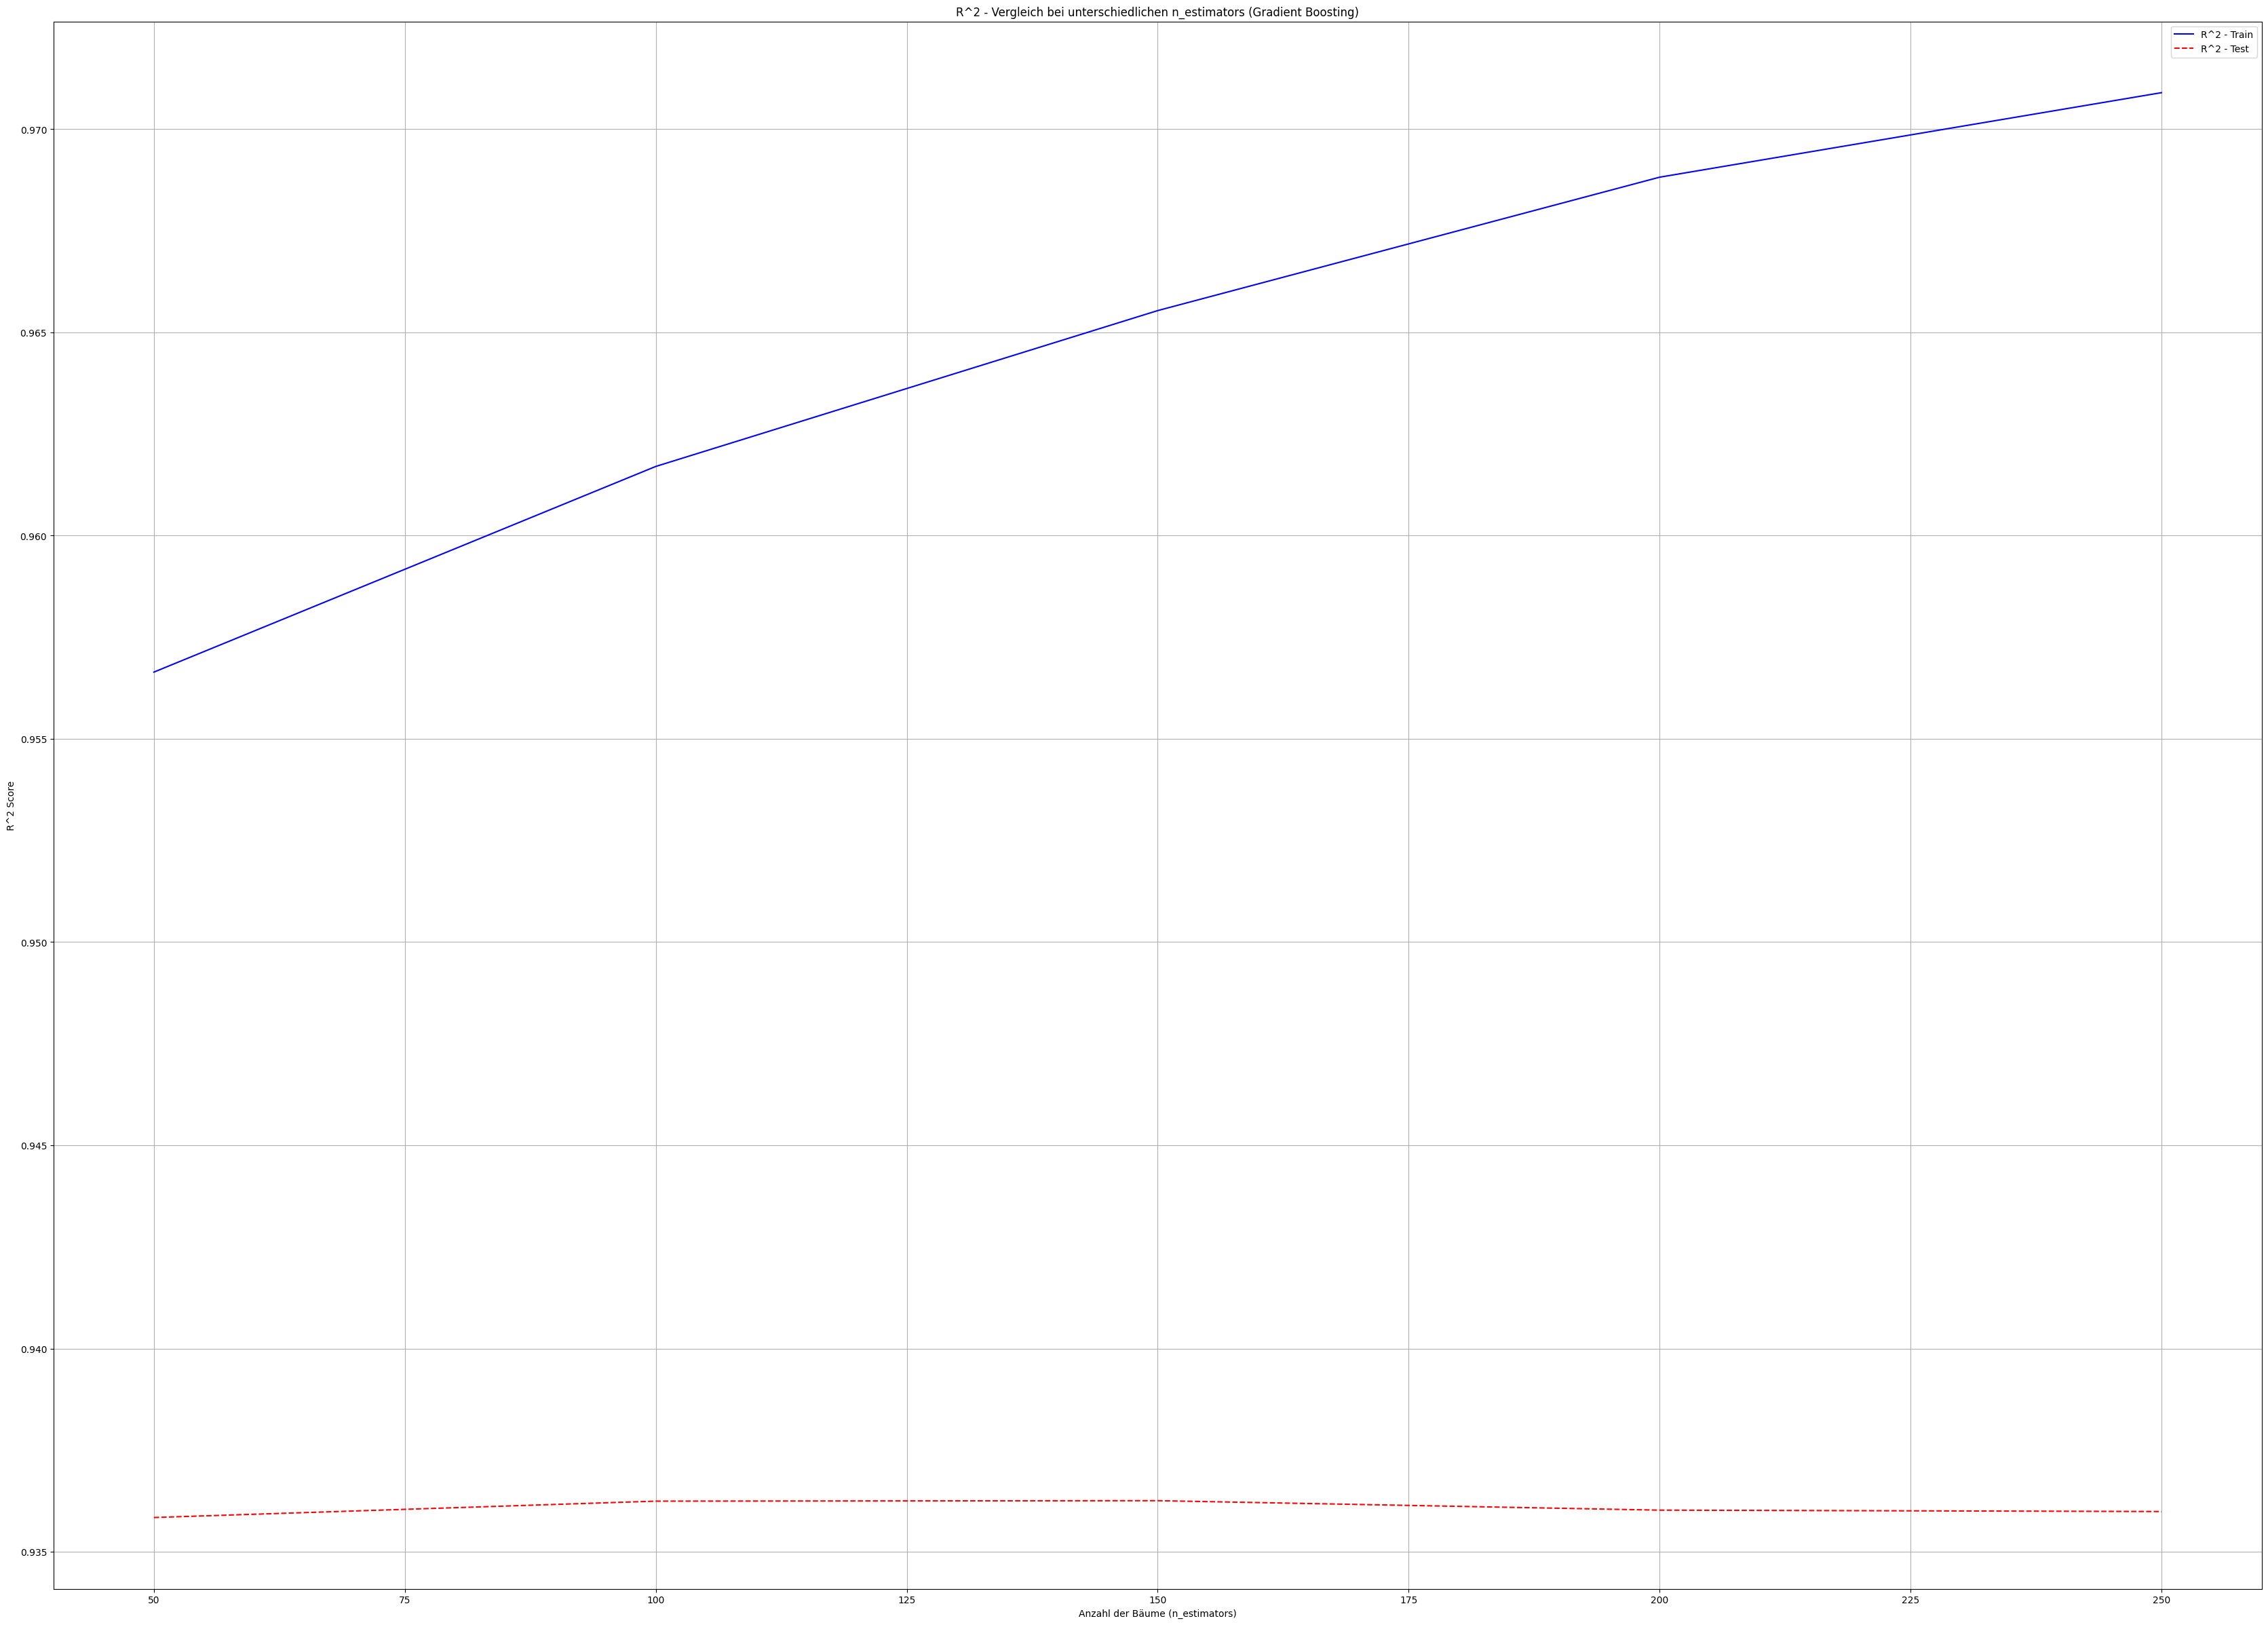

In [15]:
results_gb = {}

# Hyperparameter range
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [2]
}

for i in range(1, 7):
    print(f"Optimization and training for hour {i}...")

    target = data[f'target_h{i}']

    # Create training and test data (time series approach --> shuffle=False!)
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        test_size=0.2, 
        random_state=42,
        shuffle=False
    )

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Gradient Boosting Regressor with hyperparameters
    gbr = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=gbr,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Enable parallelization
    )
    grid_search.fit(X_train, y_train)

    # Best model
    best_gbr = grid_search.best_estimator_
    train_predictions = best_gbr.predict(X_train)
    test_predictions = best_gbr.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    results_gb[f'hour_{i}'] = { # Save
        'model': best_gbr,
        'best_params': grid_search.best_params_,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_predictions': test_predictions,
        'y_test': y_test
    }

    print(f"Results for hour {i}:") # Output
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Training RMSE: {train_rmse}")
    print(f"  Test RMSE: {test_rmse}")
    print(f"  Training R^2: {train_r2}")
    print(f"  Test R^2: {test_r2}")
    print()

n_estimators_list = []
train_score_list = []
test_score_list = []

for k in range(50, 251, 50):
    gbr = GradientBoostingRegressor(n_estimators=k, max_depth=5, learning_rate=0.1, random_state=42)
    gbr.fit(X_train, y_train)

    train_score = gbr.score(X_train, y_train)
    test_score = gbr.score(X_test, y_test)

    train_score_list.append(train_score)
    test_score_list.append(test_score)
    n_estimators_list.append(k)

# Plot
plt.figure(figsize=(42, 30))
plt.plot(n_estimators_list, train_score_list, 'b-', label='R^2 - Train')
plt.plot(n_estimators_list, test_score_list, 'r--', label='R^2 - Test')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('R^2 Score')
plt.title('R^2 - Comparison at different n_estimators (Gradient Boosting)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

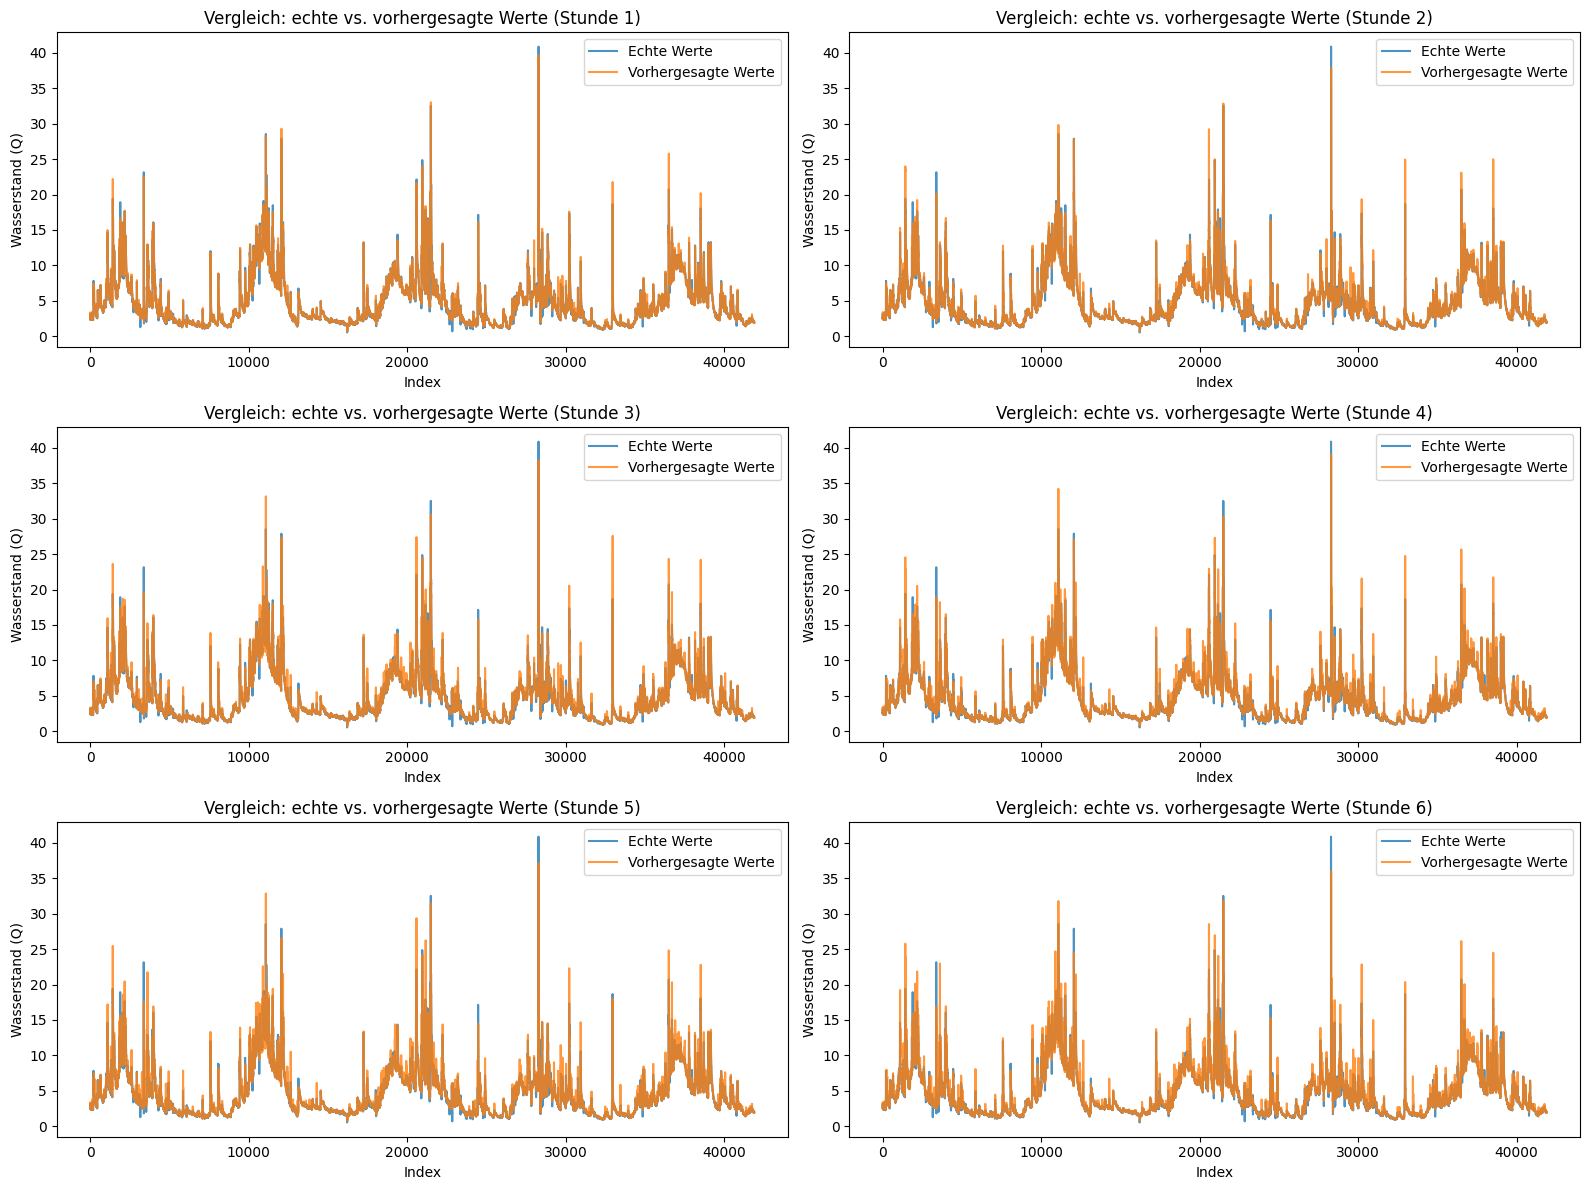

In [16]:
visualize_predictions(results_gb)

# Summary

Models and Results
 
1. Regression Tree without limiting the maximum depth (Overfitting)
	- Test RMSE (1st hour): 0.3761
 	- Test RMSE (6th hour): 0.9983
 
 Overfitting was observed, which is indicated by poorer generalization.
 
 2. Regression Tree with Hyperparameter Optimization
 
 - Optimized Hyperparameters: max_depth: 10 || min_samples_split: 2 || min_samples_leaf: 10
 - Results:
 	- Test RMSE (1st hour): 0.3635
 	- Test RMSE (6th hour): 0.8854
 
 - Feature Importance:
 	- The feature exp_smooth_Q_3h had the highest importance, while other features were negligible.

 3. Bagging with Hyperparameter Optimization
 - Optimized Hyperparameters: max_depth: 10 || min_samples_split: 2 || min_samples_leaf: 10
 - Results:
     - Test RMSE (1st hour): 0.3236
     - Test RMSE (6th hour): 0.8150
 
 4. Random Forest
 - Parameters: n_estimators: 100 || max_depth: 10
 - The best parameters from the previous optimization were used.
 - Results:
     - Test RMSE (1st hour): 0.3353
     - Test RMSE (6th hour): 0.8248
 5. Boosting
 - The Boosting model had the longest computation time.
 - Results:
     - Test RMSE (1st hour): 0.3356
     - Test RMSE (6th hour): 0.8398

---

### Conclusion
 
 1. Bagging produced the best results with a Test RMSE of 0.3236 (1st hour) and 0.8150 (6th hour).
 
 2. The influence of most features was minimal. The feature exp_smooth_Q_3h dominated in almost all models.
 
 3. Boosting delivered solid results but had a significantly longer computation time.
 
 4. Limiting the maximum depth in decision trees was crucial to avoid overfitting.
 
 5. Unfortunately, most attempts did not yield significant improvements. The regression tree might not be the most suitable for this problem, especially when compared to our other approaches.
